In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Setting library defaults

In [3]:
# code settings
pd.set_option('display.max_columns', None)

# visualization settings
plt.rc('figure', figsize=(9,9))
sns.set_style('darkgrid')

## Importing the Data

In [4]:
supp_county = pd.read_csv('../data/interim/supp_county.csv')

supp_county.head(5)

,FIPS,State,County,2010 Census Population,"Population Estimate, 2011","Population Estimate, 2012","Population Estimate, 2013","Population Estimate, 2014","Population Estimate, 2015","Population Estimate, 2016"
0,1001.0,Alabama,Autauga,"54,571","55,255","55,027","54,792","54,977","55,035","55,416"
1,1003.0,Alabama,Baldwin,"182,265","186,653","190,403","195,147","199,745","203,690","208,563"
2,1005.0,Alabama,Barbour,"27,457","27,326","27,132","26,938","26,763","26,270","25,965"
3,1007.0,Alabama,Bibb,"22,915","22,736","22,645","22,501","22,511","22,561","22,643"
4,1009.0,Alabama,Blount,"57,322","57,707","57,772","57,746","57,621","57,676","57,704"


Questions:

- What does the population of the nation look like?
- Is food insecurity changing?
- Are subfactors of insecurity correlated?
- Does higher milk/soda ratio correlate pct obsese adult?
- Does higher soda taxes lower pct obsese adult?

### supp_county

A closer look at the most recent (2016) estimated population data for each county plotted against the 2010 census data. Most of the counties have fall along a line, which looks approximately like a slope of 1, meaning that the population change was minimal. Points outside of this pseudo-regression are counties whose population changed over the 6 year span. Points above the line are counties where population increased and points below the line are a decrease in population.   

([], <a list of 0 Text yticklabel objects>)

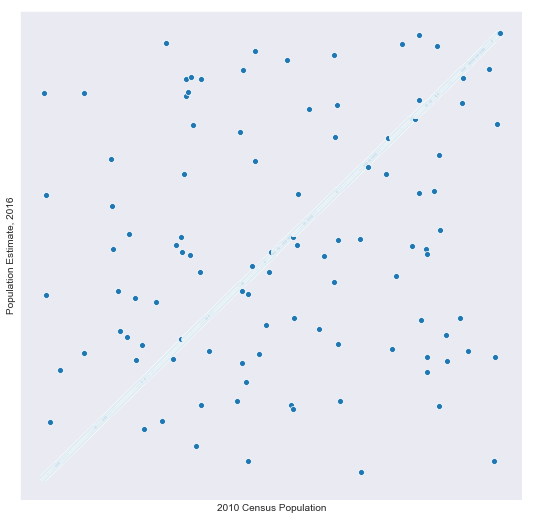

In [4]:
sns.scatterplot(x = '2010 Census Population', 
                y = 'Population Estimate, 2016',
                data = supp_county)

plt.xticks([])
plt.yticks([])

### supp_state

In [29]:
supp_state = pd.read_csv('../data/interim/supp_state.csv')
supp_state = supp_state.dropna(0)

In [32]:
supp_state.dtypes

StateFIPS                                              float64
State                                                   object
WIC participants FY 2009                                object
WIC participants FY 2011                                object
WIC participants, FY 2012                               object
WIC participants, FY 2013                               object
WIC participants, FY 2014                               object
WIC participants, FY 2015                               object
National School Lunch Program participants FY 2009      object
National School Lunch Program participants FY 2011      object
National School Lunch Program participants, FY 2012     object
National School Lunch Program participants, FY 2013     object
National School Lunch Program participants, FY 2014     object
National School Lunch Program participants, FY 2015     object
School Breakfast Program participants FY 2009           object
School Breakfast Program participants FY 2011          

In [ ]:
else:
            df.iloc[:, i] = df.iloc[:, i].str.replace(',', '')
            df.iloc[:, i] = pd.to_numeric(df.iloc[:, i])

In [39]:
def str_to_int(df, start_col, end_col):
    """Converts column to int in place.
    
    Args:
        df: the dataframe to convert
        start_col(int): the first column to convert
        end_col(int): the last column to convert
    """
    for i in range(start_col, end_col):
        if df.iloc[:, i].dtype == np.int64:
            print('hi')
        



In [42]:
supp_state.columns

Index(['StateFIPS', 'State', 'WIC participants FY 2009',
       'WIC participants FY 2011', 'WIC participants, FY 2012',
       'WIC participants, FY 2013', 'WIC participants, FY 2014',
       'WIC participants, FY 2015',
       'National School Lunch Program participants FY 2009',
       'National School Lunch Program participants FY 2011',
       'National School Lunch Program participants, FY 2012',
       'National School Lunch Program participants, FY 2013',
       'National School Lunch Program participants, FY 2014',
       'National School Lunch Program participants, FY 2015',
       'School Breakfast Program participants FY 2009',
       'School Breakfast Program participants FY 2011',
       'School Breakfast Program participants, FY 2012',
       'School Breakfast Program participants, FY 2013',
       'School Breakfast Program participants, FY 2014',
       'School Breakfast Program participants, FY 2015',
       'Child and Adult Care particpants FY 2009',
       'Child and

In [40]:
str_to_int(supp_state, 2, len(supp_state.columns))

In [8]:
supp_state['baseline'] = 0
supp_state['pop10_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2010']
supp_state['pop11_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2011']
supp_state['pop12_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2012']
supp_state['pop13_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2013']
supp_state['pop14_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2014']
supp_state['pop15_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2015']
supp_state['pop16_change'] = supp_state['State Population, 2009'] - supp_state['State Population, 2016']

pop_change = supp_state[['StateFIPS',
                         'State',
                         'baseline',
                         'pop10_change',
                         'pop11_change',
                         'pop12_change',
                         'pop13_change',
                         'pop14_change',
                         'pop15_change',
                         'pop16_change']]

pop_change = pop_change.rename(index=str, columns={'baseline': '2009',
                                            'pop10_change': '2010',
                                            'pop11_change': '2011',
                                            'pop12_change': '2012',
                                            'pop13_change': '2013',
                                            'pop14_change': '2014',
                                            'pop15_change': '2015',
                                            'pop16_change': '2016'})

pop_change = pd.melt(pop_change, 
               id_vars=['State'], 
               value_vars=['2009', '2010', '2011', '2012',
                           '2013', '2014', '2015', '2016'])

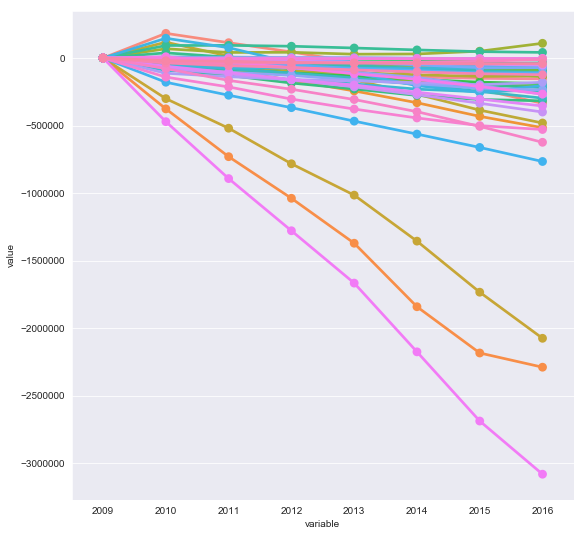

In [11]:
pop_plot = sns.pointplot(x = 'variable', y = 'value', hue = 'State', data = pop_change)

pop_plot.legend_.remove()

plt.show()

### insecurity

In [41]:
insecurity = pd.read_csv('../data/interim/insecurity.csv')

insecurity.iloc[:, 2].dtype

dtype('O')

paired t-test
why: the observations are not independent, should be highly dependent. However, since we're comparing them over time and looking at the same counties.
anova for foodinsec

for report:
Looking at the density plots for food insecurity over a 3 year span, going from 10-12 to 13-15 the variance seems to shrink while the mean stays the same. This is [XYZ] by our ANOVA

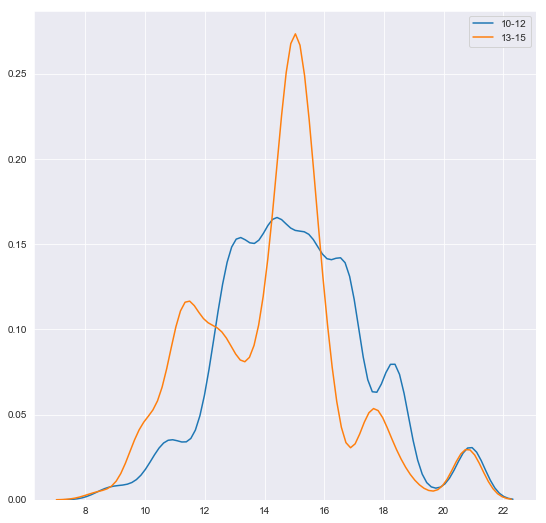

In [28]:
sns.kdeplot(insecurity['FOODINSEC_10_12'], label='10-12')
sns.kdeplot(insecurity['FOODINSEC_13_15'], label='13-15')
plt.legend()

This messy looking code reduces the dataframe to 1 observation per state and returns only the states that have had a increase in food insecurity from 2010 to 2015. 17 states including the District of Columbia saw a increase in food insecurity, 2 states saw no change and 31 states had a decrease in food insecurity.

In [40]:
insecurity.groupby(['State']).head(1)[insecurity['CH_FOODINSEC_12_15'] > 0]

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,FIPS,State,County,FOODINSEC_10_12,FOODINSEC_13_15,CH_FOODINSEC_12_15,VLFOODSEC_10_12,VLFOODSEC_13_15,CH_VLFOODSEC_12_15,FOODINSEC_CHILD_01_07,FOODINSEC_CHILD_03_11
67,2013,AK,Aleutians East,12.1,13.3,1.2,4.4,4.4,0.0,7.4,8.0
316,10001,DE,Kent,12.0,13.2,1.2,4.5,4.8,0.3,6.3,7.0
319,11001,DC,District of Columbia,11.6,11.9,0.3,4.9,3.2,-1.7,9.0,11.2
789,19001,IA,Adair,13.5,14.8,1.3,6.3,6.1,-0.2,7.5,8.3
888,20001,KS,Allen,14.4,14.6,0.2,5.5,5.5,0.0,8.8,9.3
993,21001,KY,Adair,15.6,17.6,2.0,6.2,7.3,1.1,8.0,10.0
1113,22001,LA,Acadia,15.7,18.4,2.7,4.8,7.7,2.9,9.1,9.0
1217,25001,MA,Barnstable,14.9,15.8,0.9,7.1,7.4,0.3,6.4,7.1
1231,26001,MI,Alcona,13.4,14.9,1.5,5.3,6.4,1.1,7.6,8.0
1764,33001,NH,Belknap,13.4,14.8,1.4,5.0,5.6,0.6,4.8,5.1


([], <a list of 0 Text xticklabel objects>)

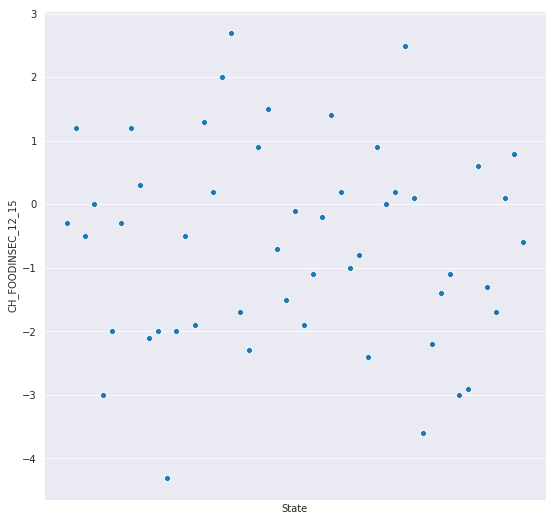

In [15]:
sns.scatterplot(x='State', y='CH_FOODINSEC_12_15', data=insecurity)
plt.xticks([])

In [1]:
sns.pairplot(insecurity)

NameError: name 'sns' is not defined

In [5]:
taxes = pd.read_csv('../data/processed/price_taxes.csv')

taxes.head(20)

,FIPS,State,County,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,SODATAX_STORES14,SODATAX_VENDM14,CHIPSTAX_STORES14,CHIPSTAX_VENDM14,FOOD_TAX14
0,1001,AL,Autauga,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
1,1003,AL,Baldwin,1.017690,1.001391,0.940165,4.0,4.0,4.0,4.0,4.0
2,1005,AL,Barbour,1.136671,0.992584,1.059400,4.0,4.0,4.0,4.0,4.0
3,1007,AL,Bibb,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
4,1009,AL,Blount,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
5,1011,AL,Bullock,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
6,1013,AL,Butler,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
7,1015,AL,Calhoun,0.970305,0.972216,0.923289,4.0,4.0,4.0,4.0,4.0
8,1017,AL,Chambers,0.856725,0.990880,0.799857,4.0,4.0,4.0,4.0,4.0
9,1019,AL,Cherokee,0.856725,0.990880,0.799857,4.0,4.0,4.0,4.0,4.0


Question:

Does higher milk/soda ratio correlate pct obsese adult?

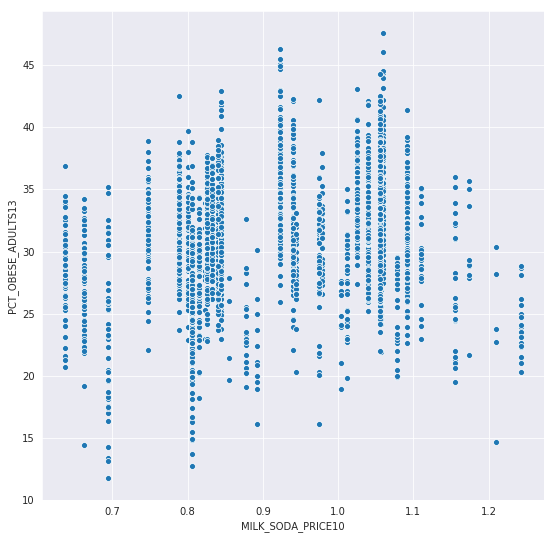

In [9]:
sns.scatterplot(x=taxes['MILK_SODA_PRICE10'], y=health['PCT_OBESE_ADULTS13'])

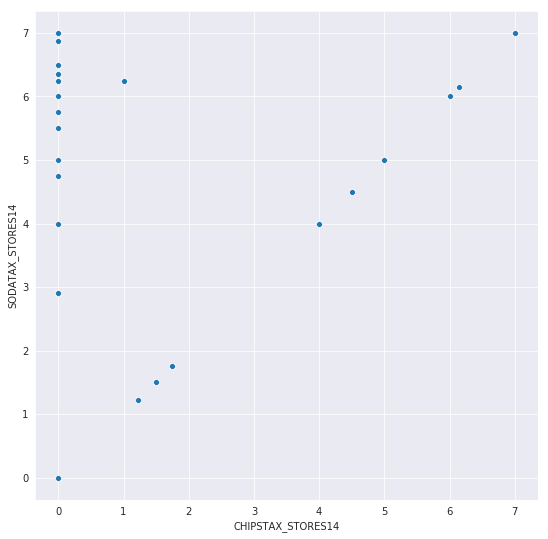

In [4]:
sns.scatterplot(x='CHIPSTAX_STORES14', y='SODATAX_STORES14', data=taxes)

In [6]:
health = pd.read_csv('../data/processed/health.csv')

health.head(1)

,FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,PCT_HSPA15,RECFAC09,RECFAC14,PCH_RECFAC_09_14,RECFACPTH09,RECFACPTH14,PCH_RECFACPTH_09_14
0,1001,AL,Autauga,11.4,13.0,31.5,34.1,25.4,4,5,25.0,0.073889,0.090261,22.156783


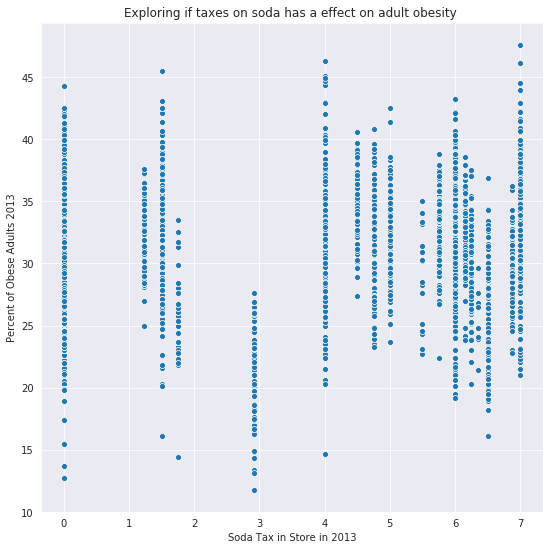

In [25]:
soda_store14_obese13 = sns.scatterplot(x=taxes['SODATAX_STORES14'], y=health['PCT_OBESE_ADULTS13'])

soda_store14_obese13.set(xlabel='Soda Tax in Store in 2013', ylabel='Percent of Obese Adults 2013', 
                         title='Exploring if taxes on soda has a effect on adult obesity ')

Question:

Does higher soda taxes lower pct obsese adult?

In [4]:
stores = pd.read_csv('../data/processed/stores.csv')

Stacked pct barplot of store types (by state)


new_df = groupby(state) sum( each column) 
total09 = sum(GROC09 + SUPERC09  + CONVS09 + SPECSPTH09 + SUPERCPTH09)
total14 = sum(GROC14 + SUPERC14  + CONVS14 + SPECSPTH14 + SUPERCPTH14)
for column in new_df:
    normalized_column = column/total00

In [4]:
stores.head(2)

,FIPS,State,County,GROC09,GROC14,PCH_GROC_09_14,GROCPTH09,GROCPTH14,PCH_GROCPTH_09_14,SUPERC09,SUPERC14,PCH_SUPERC_09_14,SUPERCPTH09,SUPERCPTH14,PCH_SUPERCPTH_09_14,CONVS09,CONVS14,PCH_CONVS_09_14,CONVSPTH09,CONVSPTH14,PCH_CONVSPTH_09_14,SPECS09,SPECS14,PCH_SPECS_09_14,SPECSPTH09,SPECSPTH14,PCH_SPECSPTH_09_14,SNAPS12,SNAPS16,PCH_SNAPS_12_16,SNAPSPTH12,SNAPSPTH16,PCH_SNAPSPTH_12_16,WICS08,WICS12,PCH_WICS_08_12,WICSPTH08,WICSPTH12,PCH_WICSPTH_08_12
0,1001,AL,Autauga,6,4,-33.333333,0.110834,0.072209,-34.849716,1,1,0.0,0.018472,0.018052,-2.274574,29,30,3.448276,0.535698,0.541565,1.095269,2,2,0.000000,0.036945,0.036104,-2.274574,37.416667,42.166667,12.694878,0.674004,0.760911,12.894172,6,5,-16.66667,0.119156,0.090067,-24.412460
1,1003,AL,Baldwin,24,29,20.833333,0.133775,0.144920,8.331001,6,6,0.0,0.033444,0.029983,-10.346758,119,118,-0.840336,0.663300,0.589673,-11.100146,21,26,23.809524,0.117053,0.129928,10.999253,138.333333,198.083333,43.192771,0.725055,0.949753,30.990390,25,27,8.00000,0.141875,0.141517,-0.252126


In [36]:
stores_breakdown = pd.DataFrame()
summed_stores = stores.groupby(['State']).sum()

# creating totals
stores_breakdown['total09'] = summed_stores['GROC09'] + summed_stores['SUPERC09'] + summed_stores['CONVS09'] + summed_stores['SPECS09']
stores_breakdown['total14'] = summed_stores['GROC14'] + summed_stores['SUPERC14'] + summed_stores['CONVS14'] + summed_stores['SPECS14']

# 2009
stores_breakdown['groc09_pct'] = summed_stores['GROC09']/stores_breakdown['total09'] * 100
stores_breakdown['superc09_pct'] = summed_stores['SUPERC09']/stores_breakdown['total09'] * 100
stores_breakdown['convs09_pct'] = summed_stores['CONVS09']/stores_breakdown['total09'] * 100
stores_breakdown['specs09_pct'] = summed_stores['SPECS09']/stores_breakdown['total09'] * 100

# 2014
stores_breakdown['groc14_pct'] = summed_stores['GROC14']/stores_breakdown['total14'] * 100
stores_breakdown['superc14_pct'] = summed_stores['SUPERC14']/stores_breakdown['total14'] * 100
stores_breakdown['convs14_pct'] = summed_stores['CONVS14']/stores_breakdown['total14'] * 100
stores_breakdown['specs14_pct'] = summed_stores['SPECS14']/stores_breakdown['total14'] * 100

In [42]:
stores_breakdown.index.name = 'state'
stores_breakdown.reset_index(inplace=True)

In [43]:
stores_breakdown.head(2)

,state,total09,total14,groc09_pct,superc09_pct,convs09_pct,specs09_pct,groc14_pct,superc14_pct,convs14_pct,specs14_pct
0,AK,459,495,46.840959,4.139434,38.562092,10.457516,43.030303,4.848485,41.212121,10.909091
1,AL,4251,4184,18.254528,2.611150,74.123736,5.010586,18.164436,2.844168,74.713193,4.278203


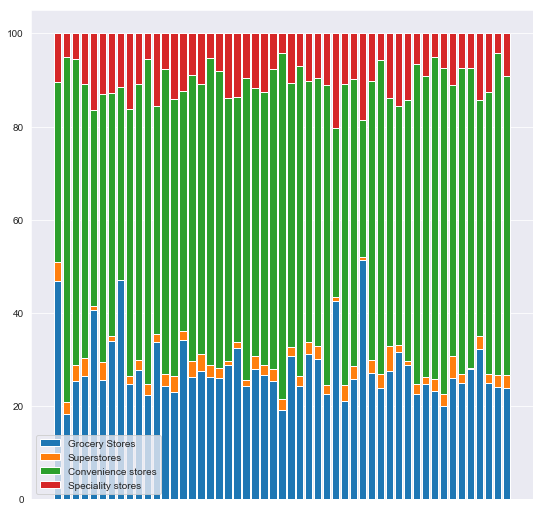

In [54]:
plt.bar(stores_breakdown['state'], stores_breakdown['groc09_pct'], label='Grocery Stores')
plt.bar(stores_breakdown['state'], stores_breakdown['superc09_pct'], bottom=stores_breakdown['groc09_pct'], label='Superstores')
plt.bar(stores_breakdown['state'], stores_breakdown['convs09_pct'], bottom=stores_breakdown['groc09_pct'] + stores_breakdown['superc09_pct'], label='Convenience stores')
plt.bar(stores_breakdown['state'], stores_breakdown['specs09_pct'], bottom=stores_breakdown['groc09_pct'] + stores_breakdown['superc09_pct'] + stores_breakdown['convs09_pct'], label='Speciality stores')

plt.xticks([])
plt.legend()

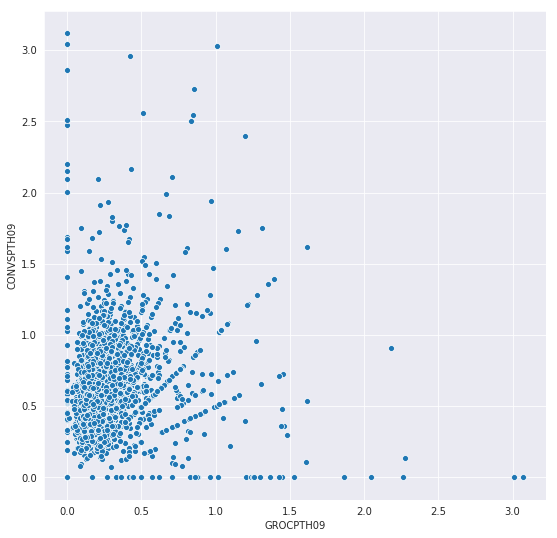

In [28]:
sns.scatterplot(x='GROCPTH09', y='CONVSPTH09', data=stores)

Do higher amounts of grocery stores mean lower amounts of convience stores?

Take pct of all stores for each, compare means

In [19]:
df = pd.read_csv('../data/interim/health.csv')


df.isna().sum()

df.head(10)

,FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,PCT_HSPA15,RECFAC09,RECFAC14,PCH_RECFAC_09_14,RECFACPTH09,RECFACPTH14,PCH_RECFACPTH_09_14
0,1001,AL,Autauga,11.4,13.0,31.5,34.1,25.4,4,5,25.000000,0.073889,0.090261,22.156783
1,1003,AL,Baldwin,9.8,10.4,26.2,27.4,25.4,18,25,38.888889,0.100331,0.124931,24.518392
2,1005,AL,Barbour,13.6,18.4,37.6,44.4,25.4,1,0,-100.000000,0.036157,0.000000,-100.000000
3,1007,AL,Bibb,11.1,14.8,32.3,40.3,25.4,1,1,0.000000,0.043590,0.044433,1.932818
4,1009,AL,Blount,11.4,14.1,31.9,34.6,25.4,3,3,0.000000,0.052319,0.051976,-0.654897
5,1011,AL,Bullock,14.9,19.6,37.8,43.0,25.4,0,0,0.000000,0.000000,0.000000,0.000000
6,1013,AL,Butler,15.1,17.7,36.8,36.3,25.4,0,1,NaN,0.000000,0.049271,NaN
7,1015,AL,Calhoun,14.5,14.9,33.5,32.2,25.4,7,7,0.000000,0.059140,0.060389,2.111011
8,1017,AL,Chambers,16.1,16.4,35.5,39.7,25.4,2,0,-100.000000,0.058167,0.000000,-100.000000
9,1019,AL,Cherokee,13.6,13.3,31.5,33.6,25.4,1,1,0.000000,0.038679,0.038407,-0.702846


In [17]:
df[df['PCT_OBESE_ADULTS13'].isna()]

,FIPS,State,County,PCT_DIABETES_ADULTS08,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS08,PCT_OBESE_ADULTS13,PCT_HSPA15,RECFAC09,RECFAC14,PCH_RECFAC_09_14,RECFACPTH09,RECFACPTH14,PCH_RECFACPTH_09_14
2916,51515,VA,Bedford,12.6,NaN,28.4,NaN,25.1,0,0,0.0,0.0,0.0,0.0


c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


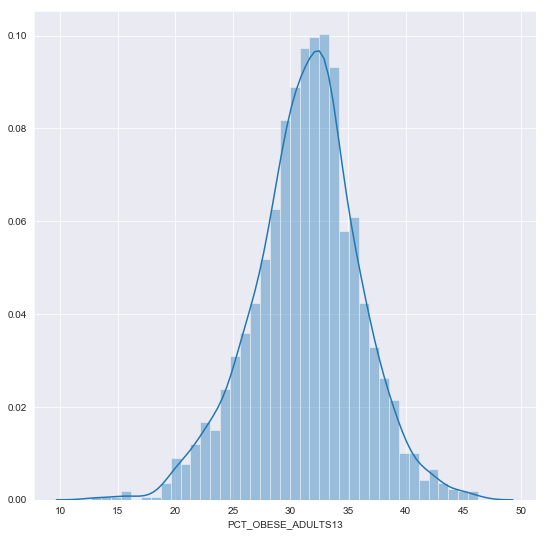

In [21]:
df.dropna(inplace=True)

sns.distplot(df['PCT_OBESE_ADULTS13'])